# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import os

from dqn_agent import Agent
from collections import deque, defaultdict
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
unity_banana_exe = os.path.join(os.getcwd(), "Banana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name=unity_banana_exe)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. DQN Training
Note: The training is stopped after receiving an average score >= **13.0** for 100 episodes

In [5]:
# DQN training   
def train_dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, min_score=13.0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    mean_scores = defaultdict(list)    # dict containing average score from each of 100 episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get state
        score = 0
        for t in range(max_t):
            # Interact with the environment 
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0] 
                  
            # Learning
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        # print out an average score for each of 100 episodes
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            mean_score = np.mean(scores_window)
            mean_scores['episode'].append(i_episode-50) # shift i episode to the center 
            mean_scores['score'].append(mean_score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        
        # reach the minimum target: save model checkpoint and stop learning
        if np.mean(scores_window) >= min_score:
            mean_score = np.mean(scores_window)
            mean_scores['episode'].append(i_episode)
            mean_scores['score'].append(mean_score)
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pth')
            print('\nSave model checkpoint')
            break

    return scores, mean_scores

Episode 100	Average Score: 0.44
Episode 200	Average Score: 3.59
Episode 300	Average Score: 7.08
Episode 400	Average Score: 9.63
Episode 500	Average Score: 12.75
Episode 514	Average Score: 13.02
Environment solved in 514 episodes!	Average Score: 13.02

Save model checkpoint


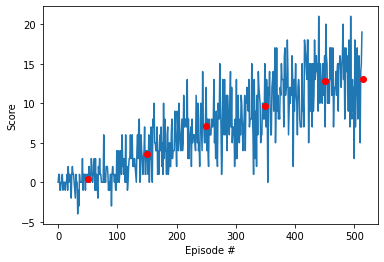

In [6]:
# Create DQN agent to learn
agent = Agent(state_size=state_size, action_size=action_size, seed=0, double_dqn=False)

# start training using default hyper-parameters
scores, mean_scores = train_dqn(agent)

# plot the scores
fig = plt.figure(1)
plt.plot(np.arange(len(scores)), scores)
plt.plot(mean_scores['episode'], mean_scores['score'], 'or')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.20
Episode 200	Average Score: 3.67
Episode 300	Average Score: 7.97
Episode 400	Average Score: 10.26
Episode 500	Average Score: 12.17
Episode 538	Average Score: 13.06
Environment solved in 538 episodes!	Average Score: 13.06

Save model checkpoint


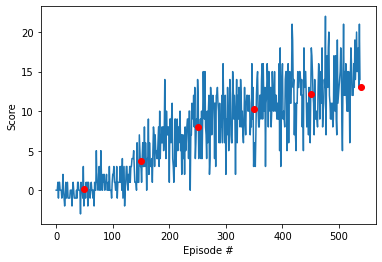

In [11]:
# Create Double DQN agent to learn
agent = Agent(state_size=state_size, action_size=action_size, seed=0, double_dqn=True)

# start training using default hyper-parameters
scores, mean_scores = train_dqn(agent)

# plot the scores
fig = plt.figure(2)
plt.plot(np.arange(len(scores)), scores)
plt.plot(mean_scores['episode'], mean_scores['score'], 'or')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4.DQN Testing

In [7]:
# Load trained model
state_dict = torch.load('model_double_dqn.pth')
print(state_dict.keys())
agent.qnetwork_local.load_state_dict(state_dict)
print(agent.qnetwork_local.fc2.weight)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
Parameter containing:
tensor([[ 0.1387, -0.1360, -0.1187,  ..., -0.1737,  0.0955,  0.0255],
        [-0.0020,  0.0320,  0.0477,  ..., -0.0259, -0.0788, -0.1897],
        [-0.0305, -0.0176, -0.1019,  ...,  0.0397, -0.0631,  0.0232],
        ...,
        [ 0.0745, -0.1860, -0.1247,  ...,  0.0536, -0.0611, -0.1335],
        [-0.0227,  0.0152,  0.3052,  ..., -0.0310, -0.1042, -0.1618],
        [-0.1205,  0.1728, -0.0718,  ...,  0.0612, -0.0247, -0.3254]], device='cuda:0')


In [8]:
# Run agent with the environment
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
eps = 0.0                                          # use greedy action or else small value 0.05 
while True:
    action = agent.act(state, eps)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 14.0


In [9]:
## close environment 
env.close()